# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# Imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col,count, desc, avg, max, min, countDistinct
from pyspark.sql import Window
from pyspark.sql.functions import sum as Fsum

import datetime
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify subset") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# read in sample data
df = spark.read.json("mini_sparkify_event_data.json")

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Gain understanding of dataset

We start by looking at some general dataset information to get a feel for what the dataset looks like

In [4]:
# investigate data schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# look at a record
df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [6]:
# total number of records
df.count()

286500

In [7]:
# total number of users
df.select("userId").dropDuplicates().count()

226

In [8]:
# Distribution of pages visited
df.groupBy("page").count().collect()

[Row(page='Cancel', count=52),
 Row(page='Submit Downgrade', count=63),
 Row(page='Thumbs Down', count=2546),
 Row(page='Home', count=14457),
 Row(page='Downgrade', count=2055),
 Row(page='Roll Advert', count=3933),
 Row(page='Logout', count=3226),
 Row(page='Save Settings', count=310),
 Row(page='Cancellation Confirmation', count=52),
 Row(page='About', count=924),
 Row(page='Submit Registration', count=5),
 Row(page='Settings', count=1514),
 Row(page='Login', count=3241),
 Row(page='Register', count=18),
 Row(page='Add to Playlist', count=6526),
 Row(page='Add Friend', count=4277),
 Row(page='NextSong', count=228108),
 Row(page='Thumbs Up', count=12551),
 Row(page='Help', count=1726),
 Row(page='Upgrade', count=499),
 Row(page='Error', count=258),
 Row(page='Submit Upgrade', count=159)]

In [9]:
# Number of users going to each page
df.select("userId","page").dropDuplicates().groupBy("page").agg({"userID":"count"}).collect()

[Row(page='Cancel', count(userID)=52),
 Row(page='Submit Downgrade', count(userID)=49),
 Row(page='Thumbs Down', count(userID)=203),
 Row(page='Home', count(userID)=224),
 Row(page='Downgrade', count(userID)=154),
 Row(page='Roll Advert', count(userID)=207),
 Row(page='Logout', count(userID)=213),
 Row(page='Save Settings', count(userID)=132),
 Row(page='Cancellation Confirmation', count(userID)=52),
 Row(page='About', count(userID)=156),
 Row(page='Submit Registration', count(userID)=1),
 Row(page='Settings', count(userID)=195),
 Row(page='Login', count(userID)=1),
 Row(page='Register', count(userID)=1),
 Row(page='Add to Playlist', count(userID)=215),
 Row(page='Add Friend', count(userID)=206),
 Row(page='NextSong', count(userID)=225),
 Row(page='Thumbs Up', count(userID)=220),
 Row(page='Help', count(userID)=193),
 Row(page='Upgrade', count(userID)=168),
 Row(page='Error', count(userID)=118),
 Row(page='Submit Upgrade', count(userID)=131)]

In [10]:
# convert ts to date
#get_date = udf(lambda x: datetime.datetime.utcfromtimestamp(x / 1000.0). date())
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).strftime('%Y-%m-%d'))
df = df.withColumn('date', get_date(df.ts))

In [11]:
# look at data time range
df.agg(min('date').alias('start_date'),max('date').alias('end_date')).show()

+----------+----------+
|start_date|  end_date|
+----------+----------+
|2018-10-01|2018-12-03|
+----------+----------+



### Define Churn

The goal for this analysis is to understand user churn.  For this study churn means that a user has confirmed cancellation of thier account (either paid or free account).  To help with future work we will identify the rows where churn transaction occurs (actions with page equal to 'Cancellation Confirmation').  Additionally for users with a churn action we will tag all of their actions with identification that they are a user with churn.

In [12]:
# create column churn to flag churn events
flag_churn = udf(lambda x: 1 if x=="Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("churn",flag_churn("page"))

# confirm count matches page='Cancellation Confirmation' count above
df.filter(df.churn==1).count() 

52

In [13]:
# create column churn_user to identify users with a churn event
windowval = Window.partitionBy("userId")
df = df.withColumn("churn_user", Fsum("churn").over(windowval))

In [14]:
# find some users with a churn action for testing
df.select("userId").filter(df.page == "Cancellation Confirmation").dropDuplicates().take(5)

[Row(userId='125'),
 Row(userId='51'),
 Row(userId='54'),
 Row(userId='100014'),
 Row(userId='101')]

In [15]:
# check columns for user 125
df.filter(df.userId=='125').select('ts','page','churn','churn_user').orderBy('ts').show()

+-------------+--------------------+-----+----------+
|           ts|                page|churn|churn_user|
+-------------+--------------------+-----+----------+
|1539317144000|            NextSong|    0|         1|
|1539317481000|            NextSong|    0|         1|
|1539317711000|            NextSong|    0|         1|
|1539317914000|            NextSong|    0|         1|
|1539318124000|            NextSong|    0|         1|
|1539318515000|            NextSong|    0|         1|
|1539318728000|            NextSong|    0|         1|
|1539318906000|            NextSong|    0|         1|
|1539318917000|         Roll Advert|    0|         1|
|1539318918000|              Cancel|    0|         1|
|1539318918000|Cancellation Conf...|    1|         1|
+-------------+--------------------+-----+----------+



### Exploratory Data Analysis

Now that we have churn identified we can start to explore the behavior of users that churn vs those that do not.  This exploration will establish some intuition regarding the data and help us prepare for feature engineering.

In [16]:
# level at time of churn
df.filter(df.churn==1).groupBy("level").count().show()

+-----+-----+
|level|count|
+-----+-----+
| free|   21|
| paid|   31|
+-----+-----+



In [17]:
# number of users by account level and churn
# note: may double count users as they could have been both levels during the span of time covered 
df.select("userId","level","churn").dropDuplicates().groupBy("level","churn").agg({"userID":"count"}).show()

+-----+-----+-------------+
|level|churn|count(userID)|
+-----+-----+-------------+
| paid|    0|          166|
| free|    0|          196|
| paid|    1|           31|
| free|    1|           21|
+-----+-----+-------------+



It is interesting to note that the users with a churn event never had a change in status (total count = 52).  However some of the users without a churn event had changes in status.

In [18]:
# average numbers of days visited by user and churn
user_visits_day = df.select('userID','churn_user','date').distinct().groupBy('userID','churn_user').count()
user_visits_day.groupBy('churn_user').agg(avg('count')).show()

+----------+------------------+
|churn_user|        avg(count)|
+----------+------------------+
|         0|15.367816091954023|
|         1| 9.826923076923077|
+----------+------------------+



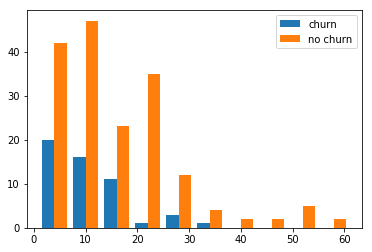

In [19]:
# plot histogram of number of days visited
visit_day_df = user_visits_day.toPandas()
plt.hist([visit_day_df[visit_day_df.churn_user==1]['count'],
          visit_day_df[visit_day_df.churn_user==0]['count']],
        label=['churn','no churn'])
plt.legend(loc='upper right')
plt.show();

Churn users tend to have less days with visits than non-churn users.  However this may be skewed as churn users may have a lower number of days that they had accounts.  We'll need to investigate total possible number of days and percent of possible days a user visited the site.

In [20]:
# total possible days by user

delta_day = udf(lambda x,y: 
            (datetime.datetime.strptime(x, '%Y-%m-%d')-datetime.datetime.strptime(y, '%Y-%m-%d')).days + 1, IntegerType())

user_possible = df.groupBy('userID','churn_user') \
    .agg(max('date').alias('end'),min('date').alias('start')) 
    
user_possible = user_possible.withColumn("days", delta_day(user_possible.end,user_possible.start))

user_possible.groupBy('churn_user').agg(avg('days')).show()


+----------+-----------------+
|churn_user|        avg(days)|
+----------+-----------------+
|         0|48.00574712643678|
|         1|24.46153846153846|
+----------+-----------------+



In [21]:
# percent of possible days visited by user
possible_df = user_possible.toPandas()
merged_usage = visit_day_df.merge(possible_df,on=['userID','churn_user'])
merged_usage['Percent_days_visited'] = merged_usage['count'] / merged_usage['days'] *100

merged_usage.groupby('churn_user')['Percent_days_visited'].mean()

churn_user
0    34.160709
1    52.465812
Name: Percent_days_visited, dtype: float64

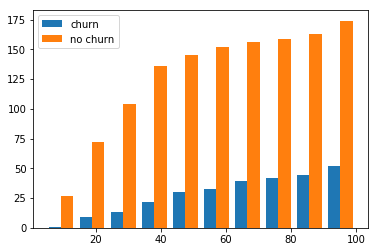

In [22]:
# Plot percent of days visited by churn
plt.hist([merged_usage[merged_usage.churn_user==1]['Percent_days_visited'],
          merged_usage[merged_usage.churn_user==0]['Percent_days_visited']],
        label=['churn','no churn'], cumulative=True)
plt.legend(loc='upper left')
plt.show();

There is a significant delta in percent of days visited between users witha nd without churn.

In [23]:
# frequency of page visits by churn

page_visits_churn = df.filter(df.churn_user==1).groupBy('page') \
    .agg(count('page').alias('visits'),countDistinct('userID').alias('users')) \
    .orderBy('visits',ascending=True).toPandas()

page_visits_nochurn = df.filter(df.churn_user==0).groupBy('page') \
    .agg(count('page').alias('visits'),countDistinct('userID').alias('users')) \
    .orderBy('visits',ascending=True).toPandas()

In [24]:
page_visits_nochurn.head()

,page,visits,users
0,Submit Registration,5,1
1,Register,18,1
2,Submit Downgrade,54,40
3,Submit Upgrade,127,102
4,Error,226,96


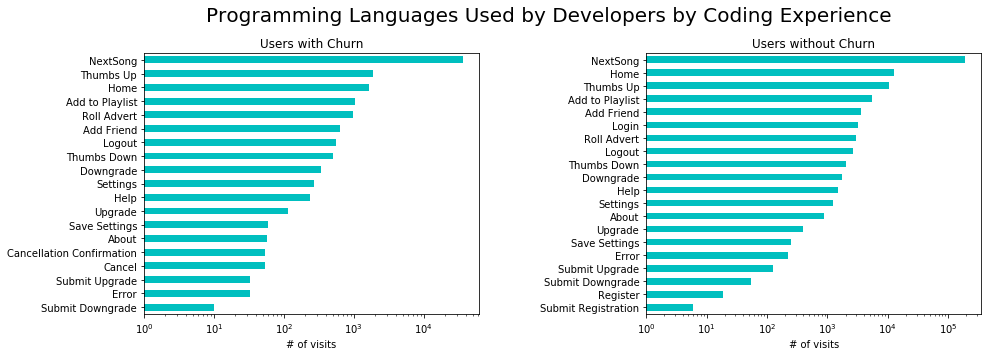

In [25]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

fig.suptitle("Programming Languages Used by Developers by Coding Experience",size=20)
fig.subplots_adjust(top=0.85)
fig.subplots_adjust(wspace=0.5)


page_visits_churn.plot.barh(x='page',y='visits',color='c',legend=False, ax=ax[0],log=True)
ax[0].set_title('Users with Churn')
ax[0].set_xlabel('# of visits')
ax[0].set_ylabel('')


page_visits_nochurn.plot.barh(x='page',y='visits',color='c',legend=False, ax=ax[1],log=True)
ax[1].set_title('Users without Churn')
ax[1].set_xlabel('# of visits')
ax[1].set_ylabel('');


In [ ]:
# number of songs listened to by day by churn

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

### References:

* https://stackoverflow.com/questions/41011002/multiple-aggregations-in-spark-structured-streaming
* https://stackoverflow.com/questions/8419564/difference-between-two-dates-in-python
* https://stackoverflow.com/questions/42586096/pyspark-assigning-name-to-column-agg-output